# Hello, FABRIC: Create your first FABRIC slice


## Configure the Environment

### Create the FABRIC Proxies

The FABRIC API is used via proxy objects that manage connections to the control framework. 


In [12]:
import os
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json

In [13]:
ssh_key_file_priv=os.environ['HOME']+"/.ssh/id_rsa"
ssh_key_file_pub=os.environ['HOME']+"/.ssh/id_rsa.pub"

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()

In [14]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
print(f"FABRIC Credential Manager   : {credmgr_host}")

orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"FABRIC Orchestrator         : {orchestrator_host}")

FABRIC Credential Manager   : beta-2.fabric-testbed.net
FABRIC Orchestrator         : beta-7.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [15]:
slice_manager = SliceManager(oc_host=orchestrator_host, 
                             cm_host=credmgr_host ,
                             project_name='all', 
                             scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [16]:
return_status, advertised_topology = slice_manager.resources()

if return_status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Toplogy: UKY: { cpu: 6/6 , core: 188/192 , ram: 1,504/1,536 G, disk: 9,400/9,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 380/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
	Site Interfaces:
		UKY_LBNL: TrunkPort { bw: 100/100 Gbps}
		UKY_RENC: TrunkPort { bw: 100/100 Gbps}
LBNL
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
	Site Interfaces:
		LBNL_RENC: TrunkPort { bw: 100/100 Gbps}
		LBNL_UKY: TrunkPort { bw: 100/100 Gbps}
RENC
	

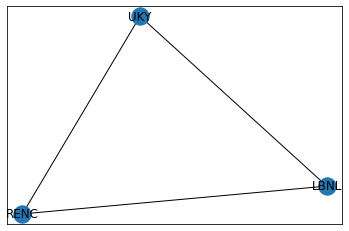

In [17]:
if return_status == Status.OK:
    advertised_topology.draw()

## Configure Slice Parameters



In [18]:
slice_name = 'MySlice'
site = 'RENC'
node_name = 'Node1'
image = 'default_centos_8'
image_type = 'qcow2'
cores = 2
ram = 16
disk = 100

## Create Slice

Creates a single node with basic compute capabilities.

<img src="./figs/SingleNode.png" width="40%"><br>


In [19]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
myExperiment = ExperimentTopology()

# Add node
myNode = myExperiment.add_node(name=node_name, site=site)

# Set capacities
cap = Capacities()
cap.set_fields(core=cores, ram=ram, disk=disk)

# Set Properties
myNode.set_properties(capacities=cap, image_type=image_type, image_ref=image)

# Generate Slice Graph
slice_graph = myExperiment.serialize()

# Request slice from Orchestrator
return_status, slice_reservations = slice_manager.create(slice_name=slice_name, slice_graph=slice_graph, ssh_key=ssh_key_pub)

if return_status == Status.OK:
    slice_id = slice_reservations[0].get_slice_id()
    print("Submitted slice creation request. Slice ID: {}".format(slice_id))
else:
    print(f"Failure: {slice_reservations}")

Submitted slice creation request. Slice ID: 14e0cb09-538a-4698-a444-5fe771a621f0


## Query Slices

You can get a list of all your slices from the slice manager. If this is your first slice, it should return only one slice.

Note that the status returned by the call to slices indicates the success or failure of the call to the FABRIC control framework. The status is not the status of the slices.  The status of each slice is included in the list of slices.

In [20]:
return_status, slices = slice_manager.slices(excludes=[SliceState.Dead])

if return_status == Status.OK:
    for slice in slices:
        print("{}:".format(slice.slice_name))
        print("   ID         : {}".format(slice.slice_id))
        print("   State      : {}".format(slice.slice_state))
        print("   Lease End  : {}".format(slice.lease_end))
        print()
else:
    print(f"Failure: {slices}")

MySlice1:
   ID         : 86a2a8c4-892b-448a-be14-1a538ea3824d
   State      : Closing
   Lease End  : 2021-09-18 14:43:56

MySlice1:
   ID         : c90f42ac-f43d-4b4d-b8c3-9c45a73bac59
   State      : Closing
   Lease End  : 2021-09-21 19:41:33

MySlice25:
   ID         : 7e9c3fdc-f431-4e2c-9569-7edc5e9713c0
   State      : Closing
   Lease End  : 2021-09-24 14:43:17

MySlice:
   ID         : 14e0cb09-538a-4698-a444-5fe771a621f0
   State      : Configuring
   Lease End  : 2021-09-24 16:46:43

MySlice24:
   ID         : 6a928953-67ab-47ec-8dc1-a1700ff74d9e
   State      : Closing
   Lease End  : 2021-09-24 14:38:24

MySlice25:
   ID         : 1945446a-ab8c-450d-82d9-65d785452005
   State      : Closing
   Lease End  : 2021-09-24 14:38:42



## Get the New Slice

You new slice is in the list of all your slices. You can loop through the list of slices to get the new slice. Python has a standard tool to filter lists. Try using a lambda function to filter out your slice using its name.

In [21]:
slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]

print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Slice Name : MySlice
ID         : 14e0cb09-538a-4698-a444-5fe771a621f0
State      : Configuring
Lease End  : 2021-09-24 16:46:43


## Wait for the Slice to Build

In [22]:
import time
def wait_for_slice(slice,timeout=180,interval=10,progress=False):
    timeout_start = time.time()

    if progress: print("Waiting for slice .", end = '')
    while time.time() < timeout_start + timeout:
        return_status, slices = slice_manager.slices(excludes=[SliceState.Dead])

        if return_status == Status.OK:
            slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
            if slice.slice_state == "StableOK":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice
            if slice.slice_state == "Closing" or slice.slice_state == "Dead":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice    
        else:
            print(f"Failure: {slices}")
        
        if progress: print(".", end = '')
        time.sleep(interval)
    
    if time.time() >= timeout_start + timeout:
        if progress: print(" Timeout exceeded ({} sec). Slice: {} ({})".format(timeout,slice.slice_name,slice.slice_state))
        return slice    

            
            
slice = wait_for_slice(slice, progress=True)
print()

print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Waiting for slice ...... Slice state: StableOK

Slice Name : MySlice
ID         : 14e0cb09-538a-4698-a444-5fe771a621f0
State      : StableOK
Lease End  : 2021-09-24 16:46:43


## Get the Slice Topology

In [ ]:
return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)

for node_name, node in experiment_topology.nodes.items():
    print("Node:")
    print("   Name              : {}".format(node.name))
    print("   Cores             : {}".format(node.get_property(pname='capacity_allocations').core))
    print("   RAM               : {}".format(node.get_property(pname='capacity_allocations').ram))
    print("   Disk              : {}".format(node.get_property(pname='capacity_allocations').disk))
    print("   Image             : {}".format(node.get_property(pname='image_ref')))
    print("   Image Type        : {}".format(node.get_property(pname='image_type')))
    print("   Host              : {}".format(node.get_property(pname='label_allocations').instance_parent))
    print("   Site              : {}".format(node.get_property(pname='site')))
    print("   Management IP     : {}".format(node.get_property(pname='management_ip')))
    print("   Reservation ID    : {}".format(node.get_property(pname='reservation_info').reservation_id))
    print("   Reservation State : {}".format(node.get_property(pname='reservation_info').reservation_state))
    print("   Components        : {}".format(node.components))
    print("   Interfaces        : {}".format(node.interfaces))
    print()    

## Log into the nodes

In [ ]:
script= '#!/bin/bash  \n' \
        'echo Hello, FABRIC from node `hostname -s`   \n'

In [ ]:
import paramiko 

key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

for node_name, node in experiment_topology.nodes.items():
    management_ip = str(node.get_property(pname='management_ip'))
    print("Node {0} IP {1}".format(node_name, management_ip))
    
    client.connect(management_ip,username='centos',pkey = key)

    stdin, stdout, stderr = client.exec_command('echo \"' + script + '\" > script.sh; chmod +x script.sh; sudo ./script.sh')
    print ('')
    print (str(stdout.read(),'utf-8').replace('\\n','\n'))

    client.close()

## Delete Slice

In [ ]:
return_status, result = slice_manager.delete(slice_object=slice)

print("Response Status {}".format(return_status))
print("Response received {}".format(result))